# Introduction
One of the benefits of the advancement of dockless bikeshare programs is that no individual station can be void of bikes to check out, or full of bikes, preventing a check in. However, dock-based bikeshare systems are still commonplace throughout the country, and due to the large capital investment they required, will likely remain so for some time. San Francisco MTA runs one of the largest dock-based bikeshare systems in the country, and has made data about its usage publicaly available.

Joining the bike usage data with weather data from Kaggle, I was able to generate a useful set of inputs that could help determine the likely number of bikes available at a given dock, based on the weather, location, day, and time.

In [1]:
import pandas as pd
import sqlite3
import numpy as np

# 1 Import, Restructure, and Clean Data
Due to the volume and variety of data in this project, I will be using python's built in SQLite RDBMS to import the data. I'll begin by defining the connection and the first query to import the weather data from the database file.

In [2]:
#define connection
conn = sqlite3.connect('database.sqlite')

In [3]:
#write query for first import (weather)
query = """SELECT date, mean_temperature_f, precipitation_inches, mean_wind_speed_mph FROM weather"""

In [4]:
#read in the weather table. set index as date to prevent multiindex default
weather = pd.read_sql_query(query, conn, parse_dates = ['date'], index_col = 'date')
weather.reset_index(inplace = True)
weather.replace("", np.nan)

,date,mean_temperature_f,precipitation_inches,mean_wind_speed_mph
0,2013-08-29,68.0,0,11.0
1,2013-08-30,69.0,0,13.0
2,2013-08-31,64.0,0,15.0
3,2013-09-01,66.0,0,13.0
4,2013-09-02,69.0,0,12.0
...,...,...,...,...
3660,2015-08-27,78.0,0,6.0
3661,2015-08-28,80.0,0,7.0
3662,2015-08-29,72.0,0,9.0
3663,2015-08-30,70.0,0,10.0


## 1.1 Cleaning Weather Data
The wether data has a huge number of NAs, as well has hundreds of duplicates. I will begin cleaning this dataset by dropping the NAs in place, sorting by date, and dropping all duplicates (using "keep first" as the rule). I will also replace all instances of "T" in the precipitation column (which indicates trace rainfall) with a values of 0.005, which will be usable in the ML algorithm. 

I'll also, throughout this cleaning process, convert columns to the appropriate data type, of the smalles bitsize that is practical for the purpose. 

In [5]:
#drop NAs from the weather table
weather.dropna(inplace = True)

In [6]:
#sort weather df by date, and drop the duplicates, keeping the first instance of each
weather.sort_values(by = 'date', inplace = True)
weather = weather[weather.mean_temperature_f != '']
weather_drop = weather.drop_duplicates(subset = 'date', keep = 'first').reset_index().drop('index', axis=1)

In [7]:
# replace all instance of T (trace) in the precip column with 0.005
weather_drop['precipitation_inches'].replace('T', 0.005, inplace = True)

In [8]:
#convert precip and temp/wind cols to flt and int dtypes respectively
weather_drop['precipitation_inches'].astype('float')
weather_drop[['mean_temperature_f', 'mean_wind_speed_mph']] = weather_drop[['mean_temperature_f', 'mean_wind_speed_mph']].astype('int')

I'll create calculated columns based on the datetime data in the date column. This will be used later in the script to merge dataframes. 

In [9]:
#extract year and day number from date col, and drop date col
weather_drop['dayofyear'] = weather_drop['date'].dt.dayofyear.astype(int)
weather_drop['year'] = weather_drop['date'].dt.year.astype(int)
weather_drop.drop('date', axis = 1, inplace = True)
weather_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_temperature_f    733 non-null    int32  
 1   precipitation_inches  733 non-null    float64
 2   mean_wind_speed_mph   733 non-null    int32  
 3   dayofyear             733 non-null    int32  
 4   year                  733 non-null    int32  
dtypes: float64(1), int32(4)
memory usage: 17.3 KB


## 1.2 Cleaning Station Data
Again, using SQLite, I will import the data that defines each station, which includes its ID number, its lat-long, and its dock count. Again, I will convert these to an appropriate type.

In [10]:
#read in station table from sql db
query = """SELECT id, lat, long, dock_count
            FROM station"""

stations = pd.read_sql_query(query, conn)
stations['dock_count'] = stations['dock_count'].astype(int)
stations.columns = ['station_id', 'lat', 'long', 'dock_count']
stations['station_id'] = stations['station_id'].astype(int)
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  70 non-null     int32  
 1   lat         70 non-null     float64
 2   long        70 non-null     float64
 3   dock_count  70 non-null     int32  
dtypes: float64(2), int32(2)
memory usage: 1.8 KB


## 1.3 Cleaing Status Data
This is the file that contains the majority of the useful information, and is by far the largest dataset I will use for this project (on the order of Gb). To deal with this without crashing my machine, I will read the data in as a CSV, in chunks of 1 million rows at a time.  I will then create an empty dataframe that has the appropriate column titles to later populate with the sampled data. 

I will employ a for loop to loop over the chunked data, and sample 10% of the data for the ML algorithm. Status data is taken for every station every ~60 seconds. By getting a 10% sample, we will get data from each station about every 10 minutes, which seems frequent enough to provide the level of precision we need. 

In [11]:
#read in status table in chunks of 10**6
status_chunk = pd.read_csv('status.csv', 
                           usecols = ['station_id', 'bikes_available', 'time'], 
                           parse_dates = ['time'], 
                           chunksize = 10**6,
                          iterator = True)

#create an empty df with the appropriate col names
status = pd.DataFrame(columns=['station_id', 'bikes_available', 'time'])

#use for loop to take samples of the chunks and append them to the the status df
for chunk in status_chunk:
    chunk = chunk.sample(frac = 0.1)
    status = status.append(chunk)

In [12]:
#convert station_id and bikes_available columns to int type
status[['station_id', 'bikes_available']] = status[['station_id', 'bikes_available']].astype(int)

In [13]:
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7198443 entries, 641875 to 71121156
Data columns (total 3 columns):
 #   Column           Dtype         
---  ------           -----         
 0   station_id       int32         
 1   bikes_available  int32         
 2   time             datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 164.8 MB


The datetime is not of particular use to me in its purest form, so I will create several new columns, and extract out more useful information, such as the day of the week, the minute in the day, and the day of the year. 

In [14]:
#break down the datetime into its individual features and drop the original datetime
status['dayofweek'] = status['time'].dt.dayofweek
status['min_in_day'] = status['time'].dt.hour * 60 + status['time'].dt.minute
status['dayofyear'] = status['time'].dt.dayofyear
status['year'] = status['time'].dt.year

status.drop('time', axis = 1, inplace = True)

status = status.astype(int)

status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7198443 entries, 641875 to 71121156
Data columns (total 6 columns):
 #   Column           Dtype
---  ------           -----
 0   station_id       int32
 1   bikes_available  int32
 2   dayofweek        int32
 3   min_in_day       int32
 4   dayofyear        int32
 5   year             int32
dtypes: int32(6)
memory usage: 219.7 MB


## 1.4 Merging Dataframes
Now that the three dataframes are cleaned up, I can merge the status and weather frames on day of year and year, and the status and station dataframes on station id.

In [15]:
#merge status and weather dfs on 'dayofyear' and 'year'. 
status = status.merge(weather_drop, how = 'left', on = ['dayofyear', 'year'])

#merge status and stations dfs on station_id
status = status.merge(stations, how = 'left', on = 'station_id')

In [16]:
#write the full merged dataframe to a csv
#status.to_csv('status_stn_wx_full.csv')

In [17]:
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7198443 entries, 0 to 7198442
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   station_id            int32  
 1   bikes_available       int32  
 2   dayofweek             int32  
 3   min_in_day            int32  
 4   dayofyear             int32  
 5   year                  int32  
 6   mean_temperature_f    int32  
 7   precipitation_inches  float64
 8   mean_wind_speed_mph   int32  
 9   lat                   float64
 10  long                  float64
 11  dock_count            int32  
dtypes: float64(3), int32(9)
memory usage: 466.8 MB


# 2 Exploratory Data Analysis

I want to look at a few of the variables in the compiled dataset, to see if they have a meaningful impact on the desired output variable. I'll do this using pyplot, in matplotlib. 

In [18]:
import matplotlib.pyplot as plt

The first thing I want to do is group by day of week, and see to what degree that impacts usage of the bikes.

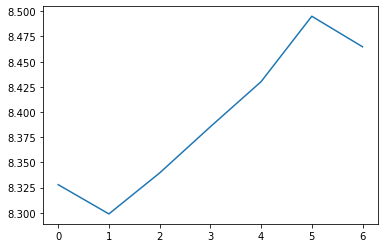

In [20]:
#plot differences in bike availability by day of the week
plt.plot(status.groupby("dayofweek").bikes_available.mean())

It looks like the day of the week does have an effect, although not as large as I was expecting. I assume this is due to the fact that generally, for most of the day, bikes are not in use almost at all. The periods of highest usage are probably relatively short.

Next, I want to see the distribution of available bike values, as well as the median and standard deviation values. This will give me some idea of what constitutes a "good" result from the algorithm.

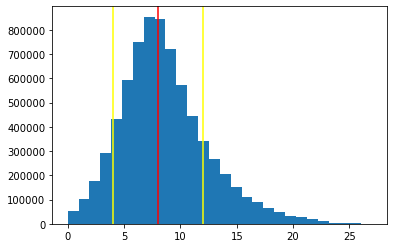

In [21]:
#plot the histogram of bike availabilities at all stations
plt.hist(status["bikes_available"], bins = (status["bikes_available"].max() + 1))
plt.axvline(status["bikes_available"].median(), color = 'red')
plt.axvline(status["bikes_available"].median() + status["bikes_available"].std(), color = 'yellow')
plt.axvline(status["bikes_available"].median() - status["bikes_available"].std(), color = 'yellow')

The values appear to be nicely distributed. Next, I want to seek how bike availability fluctuates over the course of the day. I'll do this by grouping by minute in day, the taking the mean of teh bikes available, and plotting it.

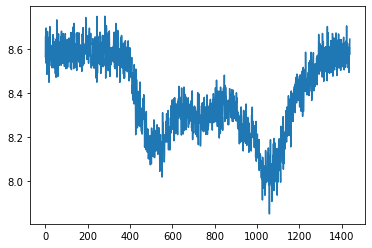

In [22]:
#plot how biek avavilability changes over the course of the day
plt.plot(status.groupby(["min_in_day"])["bikes_available"].mean())

Again, it looks like the time of day will provide useful information to out algorithm. Lastly, I want to check to see how much day of the year impacts usage. To do this, I will group by the day of the year, and take the mean of the bikes available at all stations.

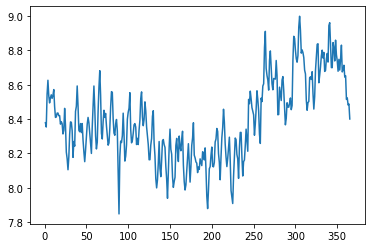

In [23]:
##plot differences in bike availability by day of the year
plt.plot(status.groupby("dayofyear").bikes_available.mean())

While this variable did not impact availability as much as I expected, it will still provide useful information for the algorithm.

# 3 Data Preprocessing
To prepare the data for the ML algorithm, I will do a few trasformations. First, I'll scale all the input variables that are not one-hot encoded using the scikit-learn standard scaler. Next, I'll create a train-test split, so that a portion of the data can be set aside to assess the goodness of fit of the model.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
#take a sample of size sample_size from status_merge to do test runs on ML model
#using the same var name so that this cell can be easily removed for a full run
sample_size = 1250000
status = status.sample(n = sample_size, random_state = 42)

In [26]:
#instantiate standard scaler
scaler = StandardScaler()

In [27]:
#scale min_in_day, lat, long, and dock_count cols
status[['mean_temperature_f','precipitation_inches', 'mean_wind_speed_mph', 'lat', 'long', 'dock_count', 'min_in_day', 'dayofyear']] = scaler.fit_transform(status[['mean_temperature_f','precipitation_inches', 'mean_wind_speed_mph', 'lat', 'long', 'dock_count', 'min_in_day', 'dayofyear']])

In [28]:
#convert station_id and year to categeoricals, then one-hot encode them
status[['station_id', 'year', 'dayofweek']] = status[['station_id', 'year', 'dayofweek']] .astype('category')
status = pd.get_dummies(status)

In [29]:
#create X and y
bikes = status['bikes_available']
status = status.drop('bikes_available', axis = 1)

In [30]:
bikes = bikes.values
status = status.values

In [31]:
#find the shape of X_scale to use as the input dimension, asigning the length and width to l and w
l, w = status.shape

In [32]:
#create a train/test split of the data set being used in the model
X_train, X_test, y_train, y_test = train_test_split(status, bikes, test_size = 0.2, random_state = 21)

# 4 Create Neural Net ML Model

To create the model that is most powerful, I will use RandomizedSearchCV, varying the number of dense layers, and the number of neurons in each layer. I'll have the search train each version over five epochs. Having run other iterations of an ML model on this data before, five seems like enough time to get a decent idea of how good the model is. 

In [ ]:
#import necessary elements of ML model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

In [34]:
#define a function that creates a keras model with parameters optimizer, 
#activation, nl (number of layers), and nn (number of neurons)
def create_model(opt = 'adam', act = 'relu', nl = 1, nn = 32):
    model = Sequential()
    model.add(Dense(nn, input_shape = (w,), activation = act))
    for i in range(nl):
        model.add(Dense(nn, activation = act))
    model.add(Dense(1, activation = act))
    model.compile(optimizer = opt, loss = 'mse', metrics = ['mse', 'mean_absolute_error'])
    return model
    
#create model as an sklearn regressor
model = KerasRegressor(build_fn = create_model, epochs = 5)

#set params to search over
params = dict(opt = ['adam'],
              act = ['relu'],
              nl = [1, 2, 3, 4],
              nn = [32, 64, 128])

In [35]:
#create random search cv object
random_search = RandomizedSearchCV(model, param_distributions = params, cv = 5, n_iter = 10)

random_search_results = random_search.fit(status, bikes)


Epoch 1/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 10.1920 - mse: 10.1920 - mean_absolute_error: 2.4290
Epoch 2/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 9.2474 - mse: 9.2474 - mean_absolute_error: 2.3097
Epoch 3/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 8.9249 - mse: 8.9249 - mean_absolute_error: 2.2659
Epoch 4/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 8.6957 - mse: 8.6958 - mean_absolute_error: 2.2315
Epoch 5/5
250000/250000 [==============================] - 3s 13us/step
Epoch 1/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 10.0390 - mse: 10.0390 - mean_absolute_error: 2.4125
Epoch 2/5
1000000/1000000 [==============================] - 28s 28us/step - loss: 9.1389 - mse: 9.1389 - mean_absolute_error: 2.2954
Epoch 3/5
1000000/1000000 [==============================] - 27s 27us/step - loss: 8.8095 - mse: 8.8095 - mean_absolute

250000/250000 [==============================] - 7s 28us/step
Epoch 1/5
1000000/1000000 [==============================] - 52s 52us/step - loss: 9.9455 - mse: 9.9455 - mean_absolute_error: 2.3998
Epoch 2/5
1000000/1000000 [==============================] - 51s 51us/step - loss: 9.0410 - mse: 9.0410 - mean_absolute_error: 2.2803
Epoch 3/5
1000000/1000000 [==============================] - 51s 51us/step - loss: 8.7314 - mse: 8.7313 - mean_absolute_error: 2.2354
Epoch 4/5
1000000/1000000 [==============================] - 51s 51us/step - loss: 8.4949 - mse: 8.4950 - mean_absolute_error: 2.2006
Epoch 5/5
250000/250000 [==============================] - 7s 29us/step
Epoch 1/5
1000000/1000000 [==============================] - 53s 53us/step - loss: 10.0358 - mse: 10.0358 - mean_absolute_error: 2.4098
Epoch 2/5
1000000/1000000 [==============================] - 52s 52us/step - loss: 9.0901 - mse: 9.0901 - mean_absolute_error: 2.2869
Epoch 3/5
1000000/1000000 [==============================] -

250000/250000 [==============================] - 15s 58us/step
Epoch 1/5
1000000/1000000 [==============================] - 67s 67us/step - loss: 10.2255 - mse: 10.2255 - mean_absolute_error: 2.4358
Epoch 2/5
1000000/1000000 [==============================] - 67s 67us/step - loss: 9.3009 - mse: 9.3009 - mean_absolute_error: 2.3198
Epoch 3/5
1000000/1000000 [==============================] - 66s 66us/step - loss: 9.0458 - mse: 9.0459 - mean_absolute_error: 2.2841
Epoch 4/5
1000000/1000000 [==============================] - 70s 70us/step - loss: 8.8645 - mse: 8.8645 - mean_absolute_error: 2.2576
Epoch 5/5
250000/250000 [==============================] - 11s 44us/step
Epoch 1/5
1000000/1000000 [==============================] - 121s 121us/step - loss: 9.8418 - mse: 9.8417 - mean_absolute_error: 2.3849
Epoch 2/5
1000000/1000000 [==============================] - 136s 136us/step - loss: 8.8128 - mse: 8.8128 - mean_absolute_error: 2.2453
Epoch 3/5
1000000/1000000 [===========================

Now I will assign the dictionary containing the optimal results of the randomized hyperparameter search to the variable "final_params," and will use this dictionary to assign teh hyperparameters to a full run of the algorithm, with as many as 25 epochs (although I will include and early stop callback, should overfitting become an issue).

In [36]:
#print the best score obtained from the RandomizedSearchCV
random_search_results.best_score_

-7.629191804406737

In [77]:
#assign the best set of parameters to final_params
final_params = random_search_results.best_params_
print(final_params)

{'opt': 'adam', 'nn': 128, 'nl': 4, 'act': 'relu'}


In [38]:
#establish the optimized model using the parameters from final_params
create_model(final_params['opt'], final_params['act'], final_params['nl'], final_params['nn'])

#set up an early stopping callback with a patience of 3
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

#run the model with 25 epochs, saving the results to history
history = model.fit(X_train, y_train, 
                    epochs = 25,
                    validation_split = 0.2,
                    callbacks = [early_stopping])

Train on 800000 samples, validate on 200000 samples
Epoch 1/25
800000/800000 [==============================] - 69s 86us/step - loss: 10.7161 - mse: 10.7160 - mean_absolute_error: 2.4941 - val_loss: 9.8637 - val_mse: 9.8637 - val_mean_absolute_error: 2.3898
Epoch 2/25
800000/800000 [==============================] - 65s 82us/step - loss: 9.6517 - mse: 9.6517 - mean_absolute_error: 2.3669 - val_loss: 9.4552 - val_mse: 9.4552 - val_mean_absolute_error: 2.3448
Epoch 3/25
800000/800000 [==============================] - 66s 83us/step - loss: 9.4300 - mse: 9.4300 - mean_absolute_error: 2.3381 - val_loss: 9.3453 - val_mse: 9.3453 - val_mean_absolute_error: 2.3276
Epoch 4/25
800000/800000 [==============================] - 65s 82us/step - loss: 9.2893 - mse: 9.2893 - mean_absolute_error: 2.3180 - val_loss: 9.2072 - val_mse: 9.2072 - val_mean_absolute_error: 2.3083
Epoch 5/25
800000/800000 [==============================] - 66s 83us/step - loss: 9.1882 - mse: 9.1882 - mean_absolute_error: 2.30

# 5 Evaluate Model

I'll begin by plotting the loss of the validation and training set over each epoch of the model.

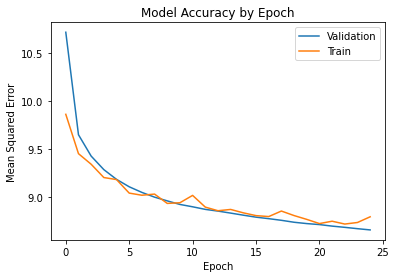

In [39]:
#plot the training and validation loss over each epoch
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend({'Train', 'Validation'})

plt.savefig('model_acc_latlong.png', dpi=300)

The training data shows a surprising amount of erratic motion, although this could be explained by the relatively small size of the set. Next, I want to see how well the predicted and actual values align. I'll do this by zipping the values together into a dataframe, and plotting using pyplot.

In [44]:
y_pred = model.predict(X_test)

In [75]:
#bind y_test and pred into a single df/ndarray and take a random sample to plot
bound_vals = pd.DataFrame(columns= ['predicted', 'actual'])
bound_vals['predicted'] = y_pred
bound_vals['actual'] = y_test

bound_vals_sample = bound_vals.sample(5000)

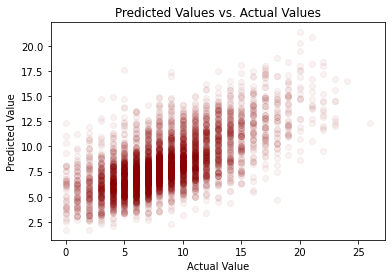

In [76]:
#plot the test vals against the predictions
plt.scatter(bound_vals_sample['actual'], bound_vals_sample['predicted'], color = 'darkred', alpha = 0.05)
plt.title('Predicted Values vs. Actual Values')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

plt.savefig('pred_act_scatter_new.png', dpi=300)